In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import io, linalg, stats, ndimage
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ldfa.ldfa as ldfa
import miccs.dynamiccs as dmx
import miccs.inference as inf

In [5]:
importlib.reload(dmx)
importlib.reload(inf)
importlib.reload(ldfa)

<module 'ldfa.ldfa' from '/home/hbong/miniconda3/lib/python3.7/site-packages/ldfa/ldfa.py'>

In [6]:
save_dir = "../data/simulation"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [7]:
np.random.seed(0)

# load data

In [8]:
data_dir = "../data/"
file_name = ['v4_lfp_bred.mat', 'pfc_lfp_bred.mat']
rec_time = [0, 0.5]

In [9]:
data_real = [h5py.File('%s/%s'%(data_dir, fname))\
        .get('lfp_bred').value[:100:2,:,:]
        for fname in file_name]

/home/hbong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hbong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
dims = [data_real[0].shape[1], data_real[1].shape[1]]
num_time = data_real[0].shape[0]
obs_trial = data_real[0].shape[2]

## cross precision

In [11]:
num_blobs = 2

In [12]:
times = np.array([[17, 10, 6], [30, 37, 9]])

In [13]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

(0.0, 1.0, 0.0, 1.0)

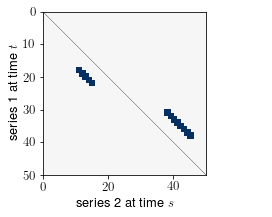

In [14]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(4,3))
gridspec.GridSpec(1,4); plt.subplot2grid((1,4), (0,0), colspan=3, rowspan=1)
dmx.imshow(np.sum(H0, 0), time=[0,50], identity=True, vmax=1)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
ax = plt.subplot2grid((1,4), (0,3))
ax.axis('off')

In [15]:
H0_islag = H0.copy()[(times[:,0]-times[:,1]) != 0]

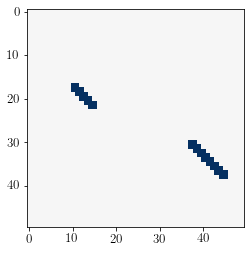

In [16]:
dmx.imshow(np.sum(H0_islag, 0))

In [17]:
H0_lag = np.full((times.shape[0], 2*num_time-1), False)
for i, H0_i in enumerate(H0_islag):
    H0_lag[i] = np.isin(np.arange(2*num_time-1), 
                        np.unique(np.sum(np.where(H0_i), 0)))

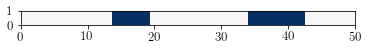

In [18]:
dmx.imshow(np.sum(H0_lag, 0)[None,:], aspect=2, extent=[0,50,0,1])

## latent precision

In [19]:
rhos = [0.105, 0.142]
precs_auto = [linalg.inv(
    np.exp(-np.square((np.arange(num_time)[:,None]-np.arange(num_time))*rho))
    + 1 * np.eye(num_time))
    for rho in rhos] 

In [20]:
snr = 0.6
prec_latent = np.array(np.block([
    [precs_auto[0]+snr*np.eye(num_time)*np.sum(H0,(0,2)), -snr*np.sum(H0,0)],
    [-snr*np.sum(H0,0).T, precs_auto[1]+snr*np.eye(num_time)*np.sum(H0,(0,1))]
]))

In [21]:
cov_latent = linalg.inv(prec_latent)
sd_latent = np.sqrt(np.diag(cov_latent))
corr_latent = cov_latent / sd_latent / sd_latent[:,None]
chol_latent = linalg.cholesky(corr_latent)

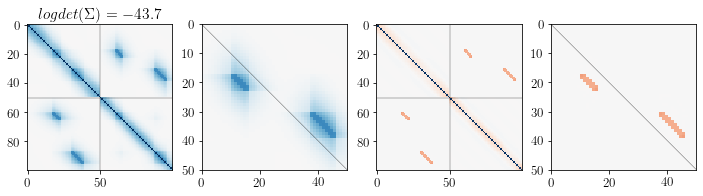

In [22]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1) 
plt.title(r'$logdet(\Sigma) = %.1f$'%(np.linalg.slogdet(corr_latent)[1]))
plt.plot([num_time, num_time], [0, 2*num_time], linewidth = 0.3, color='black')
plt.plot([0, 2*num_time], [num_time, num_time], linewidth = 0.3, color='black')
dmx.imshow(corr_latent, vmax=1)
plt.subplot(1,4,2); dmx.imshow(corr_latent[:num_time,num_time:], identity=True, time=[0,50], vmax=1)
plt.subplot(1,4,3)
plt.plot([num_time, num_time], [0, 2*num_time], linewidth = 0.3, color='black')
plt.plot([0, 2*num_time], [num_time, num_time], linewidth = 0.3, color='black')
dmx.imshow(np.linalg.inv(corr_latent), vmax=1.5)
plt.subplot(1,4,4); dmx.imshow(np.linalg.inv(corr_latent)[:num_time,num_time:], identity=True, time=[0,50], vmax=1.5)

In [23]:
lgv_latent = np.linalg.slogdet(corr_latent)[1]

## latent direction

In [24]:
dirs = [np.random.normal(np.zeros(dim), 1) for dim in dims]
dirs = [dir_i / np.sqrt(np.sum(dir_i**2)) for dir_i in dirs]

## dummy datasets

In [25]:
num_trial = 1000
lambdas_eps = np.square(np.linspace(0, np.sqrt(4), 7)[:0:-1])

In [26]:
lambdas_eps

array([4.        , 2.77777778, 1.77777778, 1.        , 0.44444444,
       0.11111111])

In [27]:
dummies = []
for iter_eps, lambda_eps in enumerate(lambdas_eps):   
    mchols = [np.array([linalg.cholesky(lambda_eps*np.cov(dat_t, bias=True)) for dat_t in dat])
          for dat in data_real]
    dummies.append(
        [dat[:,:,np.random.choice(obs_trial, num_trial, replace=True)]
         + np.matmul(mchol.transpose([0,2,1]), np.random.normal(size=(num_time,dim,num_trial)))
         for dat, dim, mchol in zip(data_real, dims, mchols)])

In [28]:
# for iter_eps, data in enumerate(datasets):
#     io.savemat('%s/data_sim_%d.mat'%(save_dir, iter_eps), {'pop_0': data[0], 'pop_1': data[1]})

In [29]:
Omegas_dmm = np.zeros(lambdas_eps.shape+(2*num_time, 2*num_time))
Sigmas_dmm = np.zeros(lambdas_eps.shape+(2*num_time, 2*num_time))

for iter_eps, dummy in enumerate(dummies):
    start_eps = time.time()
    
    m_x = [np.mean(dat, -1) for dat in dummy]
    S_xt = [np.mean([np.cov(dat_t, bias=True) for dat_t in dat], 0)
            for m, dat in zip(m_x, dummy)]
    eig_S_xt = [(w[0], v[:,0]) for w, v in [np.linalg.eig(S) for S in S_xt]]
    weight_init = [eig_S_xt[0][1].copy() for _ in np.arange(num_time)] \
            + [eig_S_xt[1][1].copy() for _ in np.arange(num_time)]
    
    Omega_dmm, Sigma_dmm, latent_dmm, weight_dmm =\
        dmx.fit(dummy, 0, 0, 0, 0, num_time, weight_init = weight_init)
    
    Omegas_dmm[iter_eps] = Omega_dmm
    Sigmas_dmm[iter_eps] = Sigma_dmm
    
    sys.__stdout__.write("%d-th simulation finished, lapse: %.3fsec.\n"
                        %(iter_eps+1, time.time()-start_eps))
    sys.__stdout__.flush()

In [30]:
show_eps = np.array([1,2,4,5]).astype(int)

In [31]:
lgvs_dmm = np.array([-np.linalg.slogdet(W)[1] for W in Omegas_dmm])

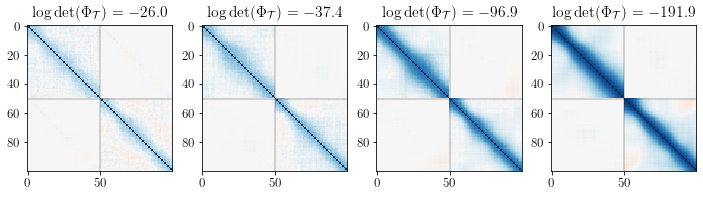

In [32]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Omegas_dmm[show_eps], lgvs_dmm[show_eps])):
    plt.subplot(1,4,i+1)
    plt.plot([num_time, num_time], [0, 2*num_time], linewidth = 0.3, color='black')
    plt.plot([0, 2*num_time], [num_time, num_time], linewidth = 0.3, color='black')
    dmx.imshow(np.linalg.inv(W))
    plt.title(r'$\log\det(\Phi_\mathcal{T}) = %.1f$'
              %(lgv_dmm))

In [33]:
dummy[0].shape

(50, 24, 1000)

In [34]:
Sigmas_avg = np.zeros(lambdas_eps.shape+(2*num_time, 2*num_time))

for iter_eps, dummy in enumerate(dummies):
    start_eps = time.time()
    
    latent_avg = [np.mean(dumm, 1) for dumm in dummy]
    Sigmas_avg[iter_eps] = np.corrcoef(latent_avg[0], latent_avg[1])
    
    sys.__stdout__.write("%d-th simulation finished, lapse: %.3fsec.\n"
                        %(iter_eps+1, time.time()-start_eps))
    sys.__stdout__.flush()

In [35]:
lgvs_avg = np.array([np.linalg.slogdet(S)[1] for S in Sigmas_avg])

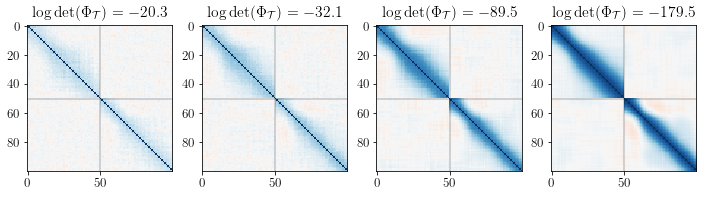

In [36]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_avg[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1)
    plt.plot([num_time, num_time], [0, 2*num_time], linewidth = 0.3, color='black')
    plt.plot([0, 2*num_time], [num_time, num_time], linewidth = 0.3, color='black')
    dmx.imshow(W)
    plt.title(r'$\log\det(\Phi_\mathcal{T}) = %.1f$'
              %(lgv_dmm))

## simulation

In [37]:
datasets = []
for iter_eps, dummy in enumerate(dummies):   
    ldummy = [dir_i @ (dumm - np.mean(dumm, -1, keepdims=True))
              for dir_i, dumm in zip(dirs, dummy)]
    cov_ldummy = np.cov(ldummy[0], ldummy[1])
    sd_ldummy = np.sqrt(np.diag(cov_ldummy))
    
    lv = (chol_latent.T @ np.random.normal(0, 1, (2*num_time, num_trial)))
    
    datasets.append(
        [dummy[0] + dirs[0][None,:,None] * (sd_ldummy[:num_time,None,None]*lv[:num_time,None,:]),
         dummy[1] + dirs[1][None,:,None] * (sd_ldummy[num_time:,None,None]*lv[num_time:,None,:])])
    
#     datasets.append(
#         [dummy[0] + dirs[0][None,:,None] * (sd_ldummy[:num_time,None,None]*lv[:num_time,None,:]-ldummy[0][:,None,:]),
#          dummy[1] + dirs[1][None,:,None] * (sd_ldummy[num_time:,None,None]*lv[num_time:,None,:]-ldummy[1][:,None,:])])

In [38]:
# for iter_eps, data in enumerate(datasets):
#     io.savemat('%s/data_sim_%d.mat'%(save_dir, iter_eps), {'pop_0': data[0], 'pop_1': data[1]})

# parameters

In [39]:
offset_cross = 10
offset_auto = 5
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.2), np.log(0.002), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.full((11,), 0), ## lambdas_auto
    np.full((11,), 0), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [40]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[2]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.07962143411069945, 0.0, 0.0, 0.0)

In [41]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [42]:
lambda_glasso = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

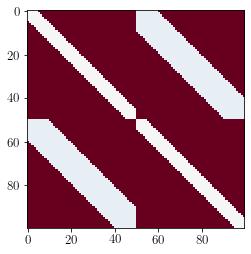

In [43]:
dmx.imshow(lambda_glasso)

In [44]:
max_dfa = 1000
max_lasso = 1000
max_glasso = 1000
ths = 1e-5

# DynaMICCS

In [45]:
Omegas_dmx = np.zeros((len(lambdas_eps),2*num_time,2*num_time))
Sigmas_dmx = np.zeros((len(lambdas_eps),2*num_time,2*num_time))

for i, data in enumerate(datasets):
    # initialization by CCA
    start_dmx = time.time()
    
    S_xt = np.cov(*[dat.transpose([1,0,2]).reshape([d,-1])
                for dat, d in zip(data, dims)])
    S_1 = S_xt[:dims[0],:dims[0]]
    S_12 = S_xt[:dims[0],dims[0]:]
    S_2 = S_xt[dims[0]:,dims[0]:]

    U_1= linalg.inv(linalg.sqrtm(S_1))
    U_2 = linalg.inv(linalg.sqrtm(S_2))
    
    u, s, vh = np.linalg.svd(U_1 @ S_12 @ U_2)
    weight_init = [(U_1 @ u[:,0]).copy() for _ in np.arange(num_time)] \
                + [ (U_2 @ vh[0]).copy() for _ in np.arange(num_time)]
    
    # fit DynaMICCS
    Omega_est, Sigma_est, latent_est, weight_est =\
        dmx.fit(data, lambda_diag, lambda_cross, offset_cross,
                lambda_auto, offset_auto,
                weight_init = weight_init)
    
    Omegas_dmx[i] = Omega_est
    Sigmas_dmx[i] = Sigma_est
    
    sys.__stdout__.write('%d-th simulation on DynaMICCS finished, lapse: %.3fs \n'
                         %(i+1, time.time()-start_dmx))
    sys.__stdout__.flush()

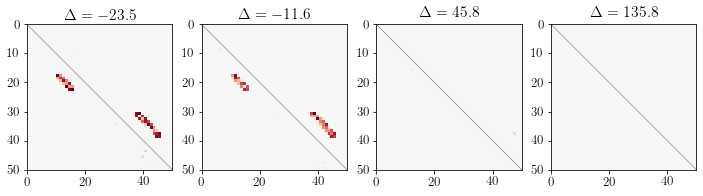

In [46]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Omegas_dmx[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1)
    dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.2, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

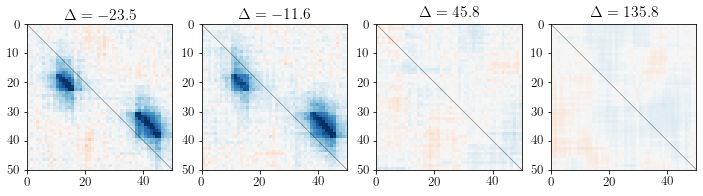

In [47]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_dmx[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1); dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.5, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

# LDFA-H
## default initialization

In [48]:
Omegas_ldfa = np.zeros((len(lambdas_eps),2*num_time,2*num_time))
Sigmas_ldfa = np.zeros((len(lambdas_eps),2*num_time,2*num_time))

for i, data in enumerate(datasets): 
    start_cdfa = time.time() 
    
    # fit dfa
    Omega_est, Sigma_est, params_est =\
        ldfa.fit(data, lambda_cross, offset_cross,
                 lambda_auto, offset_auto, ths_glasso=1e-8, ths_lasso=1e-8)
    
    Omegas_ldfa[i] = Omega_est
    Sigmas_ldfa[i] = Sigma_est
    
    sys.__stdout__.write('%d-th simulation on LDFA-H finished, lapse: %.3fs \n'
                         %(i+1, time.time()-start_cdfa))
    sys.__stdout__.flush()

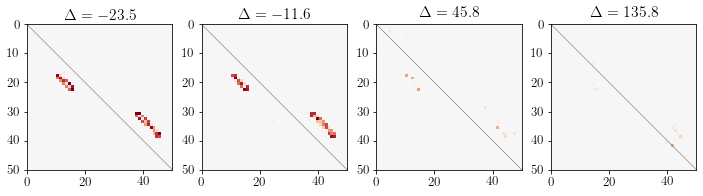

In [49]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Omegas_ldfa[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1)
    dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.2, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

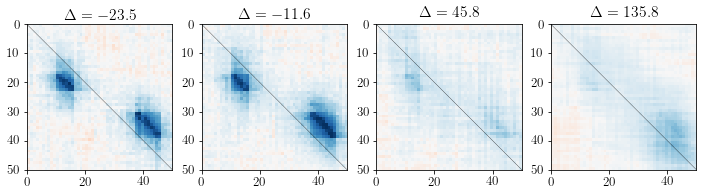

In [50]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_ldfa[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1); dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.5, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

## another initialization

In [51]:
time_graph_cross = (np.abs(np.arange(num_time)-np.arange(num_time)[:,None])<offset_cross)

In [52]:
Omegas_ldfa_1 = np.zeros((len(lambdas_eps),2*num_time,2*num_time))
Sigmas_ldfa_1 = np.zeros((len(lambdas_eps),2*num_time,2*num_time))

for i, data in enumerate(datasets): 
    start_cdfa = time.time() 
    
    CCA_ts = np.zeros((num_time, num_time))
    for t, s in zip(*np.where(time_graph_cross)):
        S_ts = np.cov(data[0][t], data[1][s], bias=True)
        S_1 = S_ts[:dims[0],:dims[0]]
        S_12 = S_ts[:dims[0],dims[0]:]
        S_2 = S_ts[dims[0]:,dims[0]:]

        U_1= linalg.inv(linalg.sqrtm(S_1))
        U_2 = linalg.inv(linalg.sqrtm(S_2))

        u, l, vh = np.linalg.svd(U_1 @ S_12 @ U_2)
        CCA_ts[t,s] = l[0]
    
    t, s = np.where(CCA_ts == np.max(CCA_ts))
    S_ts = np.cov(data[0][t[0]], data[1][s[0]], bias=True)
    S_1 = S_ts[:dims[0],:dims[0]]
    S_12 = S_ts[:dims[0],dims[0]:]
    S_2 = S_ts[dims[0]:,dims[0]:]

    U_1= linalg.inv(linalg.sqrtm(S_1))
    U_2 = linalg.inv(linalg.sqrtm(S_2))

    u, l, vh = np.linalg.svd(U_1 @ S_12 @ U_2)
    weights = [(U_1 @ u[:,0]).copy(), (U_2 @ vh[0]).copy()]
    
    # fit dfa
    Omega_est, Sigma_est, params_est =\
        ldfa.fit(data, lambda_cross, offset_cross,
                 lambda_auto, offset_auto, ths_glasso=1e-8, ths_lasso=1e-8,
                 beta_init = weights)
    
    Omegas_ldfa_1[i] = Omega_est
    Sigmas_ldfa_1[i] = Sigma_est
    
    sys.__stdout__.write('%d-th simulation on LDFA-H finished, lapse: %.3fs \n'
                         %(i+1, time.time()-start_cdfa))
    sys.__stdout__.flush()

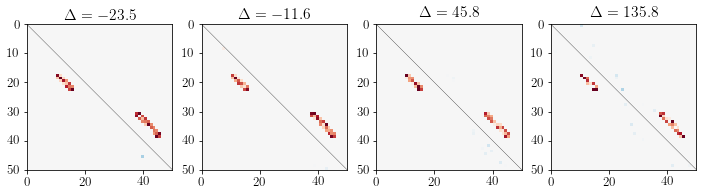

In [53]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Omegas_ldfa_1[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1)
    dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.2, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

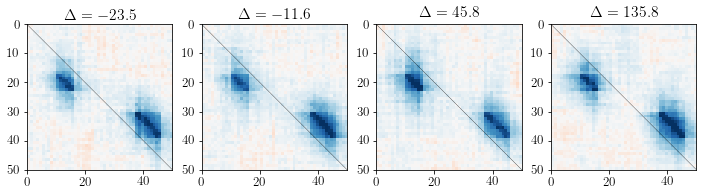

In [54]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_ldfa_1[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1); dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.5, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

# APC (Averaged Pairwise Correlation)

In [55]:
Sigmas_apc = np.zeros((len(lambdas_eps),2*num_time,2*num_time))

for i, data in enumerate(datasets): 
    start_apc = time.time() 
    
    # fit dfa
    for j in np.arange(dims[0]):
        for k in np.arange(dims[1]):
            Sigmas_apc[i] += np.corrcoef(data[0][:,j,:], data[1][:,k,:])
    Sigmas_apc[i] /= dims[0] * dims[1]
    
    sys.__stdout__.write('%d-th simulation on APC finished, lapse: %.3fs \n'
                         %(i+1, time.time()-start_apc))
    sys.__stdout__.flush()

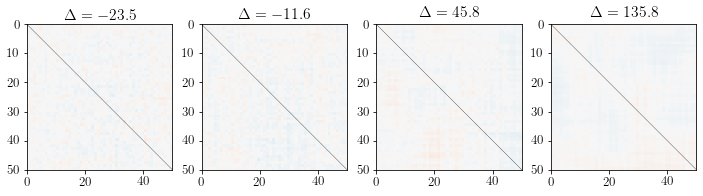

In [56]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_apc[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1); dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.5, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

# CAS (Correlation of Averaged Signals)

In [57]:
Sigmas_cas = np.zeros((len(lambdas_eps),2*num_time,2*num_time))

for i, data in enumerate(datasets): 
    start_cas = time.time() 
    
    # fit dfa
    for j in np.arange(dims[0]):
        for k in np.arange(dims[1]):
            Sigmas_cas[i] = np.corrcoef(np.mean(data[0],1), 
                                        np.mean(data[1],1))
    
    sys.__stdout__.write('%d-th simulation on CAS finished, lapse: %.3fs \n'
                         %(i+1, time.time()-start_cas))
    sys.__stdout__.flush()

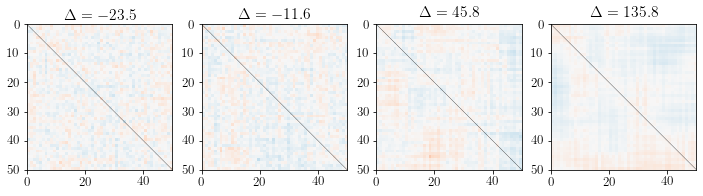

In [58]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_cas[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1); dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.5, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

# CCA

In [59]:
Sigmas_cca = np.zeros((len(lambdas_eps),2*num_time,2*num_time))

for i, data in enumerate(datasets):
    # initialization by CCA
    start_cca = time.time()
    
    S_xt = np.cov(*[dat.transpose([1,0,2]).reshape([d,-1])
                for dat, d in zip(data, dims)])
    S_1 = S_xt[:dims[0],:dims[0]]
    S_12 = S_xt[:dims[0],dims[0]:]
    S_2 = S_xt[dims[0]:,dims[0]:]

    U_1= linalg.inv(linalg.sqrtm(S_1))
    U_2 = linalg.inv(linalg.sqrtm(S_2))
    
    u, s, vh = np.linalg.svd(U_1 @ S_12 @ U_2)
    weights = [(U_1 @ u[:,0]).copy(), (U_2 @ vh[0]).copy()]
        
    Sigmas_cca[i] = np.corrcoef(*[np.tensordot(w, dat, (0,1))
                                  for w, dat in zip(weights, data)])
    
    sys.__stdout__.write('%d-th simulation on CCA finished, lapse: %.3fs \n'
                         %(i+1, time.time()-start_cca))
    sys.__stdout__.flush()

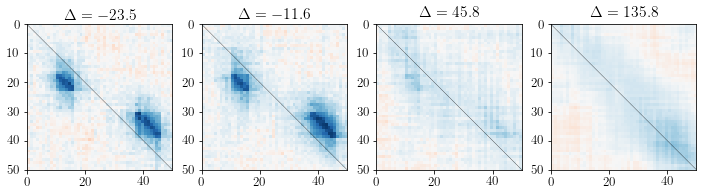

In [60]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_cca[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1); dmx.imshow(W[:num_time,num_time:], identity=True, vmax=0.5, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))

# DKCCA

In [61]:
Sigmas_dkcca = np.zeros((len(lambdas_eps),num_time,num_time))
for iter_eps, data in enumerate(datasets):
    latent_dkcca = io.loadmat('%s/result_DKCCA_%d.mat'%(save_dir,iter_eps))['latent_DKCCA']
    latent_dkcca = np.concatenate([latent_dkcca[0,0].T, latent_dkcca[1,0].T], 0)
    Sigmas_dkcca[iter_eps] = np.corrcoef(latent_dkcca)

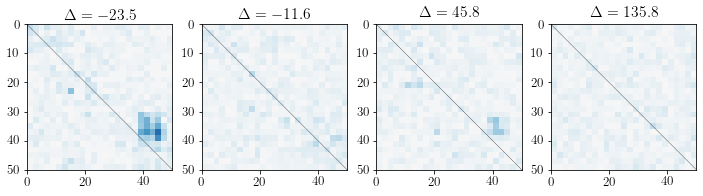

In [62]:
plt.figure(figsize=(12, 3))
for i, (l, W, lgv_dmm) in enumerate(zip(
    lambdas_eps[show_eps], Sigmas_dkcca[show_eps], lgvs_avg[show_eps])):
    plt.subplot(1,4,i+1); dmx.imshow(np.abs(W)[:25,25:], identity=True, vmax=0.5, time=[0,50])
    plt.title(r'$\Delta = %.1f$'%(lgv_latent-lgv_dmm))